# Code to show a plot of Radio Power vs redshift.

We want to compare data from several surveys and catalogs in order to  
place them in the Radio Power ($L_{1.4}$) - redshift ($z$) plane.

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```


In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patheffects as path_effects
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Polygon
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.table import Table
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
import getpass

Now, we define some functions to be used for calculations.

One function, to derive luminosity distances

In [2]:
def luminosity_distance(z_i, H0=70., WM=0.3, WV=0.7):
    z_i   = np.array([z_i], dtype='float64').flatten()
    c     = 299792.458 # velocity of light in km/sec
    h     = H0 / 100.
    WR    = 4.165E-5 / (h * h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK    = 1 - WM - WR - WV
    azs   = 1.0 / (1 + z_i)
    DTT   = 0.0
    DCMR  = 0.0
    # do integral over a=1/(1+z) from az to 1 in n steps, midpoint rule
    n     = 1000  # number of points in integrals
    DL_Mpcs = np.zeros_like(z_i)
    for count, az in enumerate(azs):
        a     = az + (1 - az) * (np.arange(0, n) + 0.5) / n
        adot  = np.sqrt(WK + (WM / a) + (WR / (a * a)) + (WV * a * a))
        for i in range(n):
            # a    = az + (1 - az) * (i + 0.5) / n
            # adot = math.sqrt(WK + (WM / a) + (WR / (a * a)) + (WV * a * a))
            DTT  = DTT + 1. / adot[i]
            DCMR = DCMR + 1. / (a[i] * adot[i])
        DTT   = (1. - az) * DTT / n
        DCMR  = (1. - az) * DCMR / n
        # tangential comoving distance
        ratio = 1.00
        x     = np.sqrt(abs(WK)) * DCMR
        if x > 0.1:
            if WK > 0:
                ratio =  0.5 * (np.exp(x) - np.exp(-x)) / x 
            else:
                ratio = np.sin(x) / x
        else:
            y = x * x
        if WK < 0: y = -y
        ratio  = 1. + y / 6. + y * y / 120.
        DCMT   = ratio * DCMR
        DA     = az * DCMT
        DL     = DA / (az * az)
        DL_Mpc = (c / H0) * DL
        DL_Mpcs[count] = DL_Mpc
    return DL_Mpcs

Now, a function to create some gradients in the plots

In [3]:
def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [4]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [5]:
alpha_used  = alpha_butl

---

### Reading data

Next step, reading our data.
Most of the data files have been created using Topcat

In [6]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

Read data from FIRST+MILLIQUAS catalogs cross-matched.  

**MILLIQUAS + FIRST (SDSS)**   

Redshift values have been retrieved from the column `pipeline_redshift` in SDSS DR12  
The procedure to obtain these values is explained in **Bolton+2012**  

We also select sources with have explicitely data in both SDSS Quasar Catalog and  
in the FIRST survey (`first_match_flag = 1`).  

In order to get only the best redshift values, we select sources with  
`pipeline_redshift_flag = 0`.

Thus, we can use 9161 objects from the catalog.

In [7]:
hdu_list = fits.open(cat_path + 'tables_matches_milli_sdss_apr.fits');

# wise_milli  = Table(hdu_list[1].data);
sdss_milli  = Table(hdu_list[1].data);
# match_table = Table(hdu_list[3].data);  # Three tables cross-matched
hdu_list.close();

L_14GHz_filter = np.array(sdss_milli['L_14GHz'] > 0.0);  # sdss + milliquasar

Read data from **Wold+2012** VLA observations + redshifts  
199 sources used from A370 and A2390  
Only those from A370 have spectroscopic redshift values

In [8]:
#hdu_wold    = fits.open(cat_path + 'J_ApJS_202_2_table2.dat.fits')
hdu_wold    = fits.open(cat_path + 'table2.fits')

wold_data   = Table(hdu_wold[1].data)

redshift_wold   = wold_data['z'][(wold_data['z'] > 0) * (wold_data['ACO'] == 370)]
peak_14GHz_wold = wold_data['Stot'][(wold_data['z'] > 0) * (wold_data['ACO'] == 370)]
lum_dist_wold   = luminosity_distance(redshift_wold) * 3.086e22
hdu_wold.close()

/home/rcarvajal/.anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


Read data from **Owen+ 2018**, JVLA observations + redshifts  
GOODS-N field --- 734 sources used --- scpectroscopic z only

In [9]:
hdu_owen    = fits.open(cat_path + 'J_ApJS_235_34_table1.dat.fits');

owen_data   = Table(hdu_owen[1].data);

redshift_owen   = owen_data['z'][(owen_data['z'] > 0) * (owen_data['f_z'] == 's')];
peak_14GHz_owen = owen_data['Total'][(owen_data['z'] > 0) * (owen_data['f_z'] == 's')];
lum_dist_owen   = luminosity_distance(redshift_owen) * 3.086e22;

hdu_owen.close();

Read data from **Cooper+2007** VLA observations  
which have been selected from VLBI 2cm observations

In [10]:
hdu_cooper = fits.open(cat_path + 'J_ApJS_171_376_table2.dat.fits')

cooper_data   = Table(hdu_cooper[1].data)

redshift_cooper   = cooper_data['z'][cooper_data['z'] > 0]
peak_14GHz_cooper = cooper_data['Score'][cooper_data['z'] > 0]  # in Jy
lum_dist_cooper   = luminosity_distance(redshift_cooper) * 3.086e22

hdu_cooper.close()

Read data from the cross-matching between VLA, XMM and COSMOS  
This data has been obtained from the VLA-COSMOS 3 GHz Large Project  
**Smolčić et al. 2017**

We can, also, separate sources which have an AGN X-ray counterpart  
with the flag `xray_flag`

In [11]:
hdu_cosmos         = fits.open(cat_path + 'vla_xmmcosmos_smolcic.fits')

cosmos_data        = Table(hdu_cosmos[1].data)

x_ray_flag         = cosmos_data['xray_flag']
redshift_cosmos    = cosmos_data['z'][(cosmos_data['z'] > 0) * (cosmos_data['xray_flag'] == 'F')]
int_14GHz_cosmos   = 10**cosmos_data['log_lum_20cm'][(cosmos_data['z'] > 0) * (cosmos_data['xray_flag'] == 'F')]
# lum_dist_cosmos  = cosmos_data['lum_dist'][(cosmos_data['spec_z'] > 0)]  # in m

redshift_cosmos_x  = cosmos_data['z'][(cosmos_data['z'] > 0) * (cosmos_data['xray_flag'] == 'T')]
int_14GHz_cosmos_x = 10**cosmos_data['log_lum_20cm'][(cosmos_data['z'] > 0) * (cosmos_data['xray_flag'] == 'T')]

hdu_wold.close()

Add data from different and individual sources  
In that same order;

- **Aztec-1**
- **M82**
- **Himiko**
- **Arp 220**
- **J1342+0928 (Bañados+2018)**
- **TGSS J1530+1049 (Saxena+2018)**
- **J0100+2802 (Wang+2017)**
- **J0439+1634 (Yang+2019)**

In [12]:
indiv_zs     = np.array([4.3415, 0.00068, 6.595, 0.01813, 7.5413, 5.72, 6.327, 6.5])
indiv_flx    = np.array([48, 7.386e6, 100, 3.2e5, 432, 7500, 104.5 * (3/1.4)**alpha_used, 28.9 * (3/1.4)**alpha_used])  # uJy (always converted to 1.4GHz)
indiv_flx_e  = np.array([12, 0.0, 50, 0.0, 216, 0.0, 3.1, 4.5])  # From literature, or 25% of value for upper limits
indiv_lum_d  = luminosity_distance(indiv_zs) * 3.086e22  # in m
indiv_names  = np.array(['AzTEC-1', 'M82', 'Himiko', 'Arp 220', 'J1342+0928', 'TGSS J1530+1049', 'J0100+2802', 'J0439+1634'])
indiv_up_lim = np.array([False, False, True, False, True, False, False, False])

We want, also, to add $z > 6$ QSOs from the list in  
Table 3 in the review of **Inayoshi, Visbal, and Haiman, 2020**.  
Six of them have $z > 7$

Not all of them have $1.4$ GHz measurements. Others have  
measurements in different frequencies which can be translated  
into the desired frequency using, for instance, the relation  
from **Butler et al., 2018**:

$$S_{a} = S_{b} \times (\frac{\nu_{b}}{\nu_{a}})^{\alpha}$$


We load the data from these sources. Fluxes from different frequencies than $1.4$ GHz are translated to the needed value.

In [13]:
high_z_zs       = np.char.replace(np.loadtxt(cat_path + 'high_z_qso_props.csv', usecols=[3],  dtype='str', delimiter='\t'), ',', '.').astype(np.float)
high_z_zs_e     = np.char.replace(np.loadtxt(cat_path + 'high_z_qso_props.csv', usecols=[4],  dtype='str', delimiter='\t'), ',', '.').astype(np.float)
high_z_14GHz    = np.char.replace(np.loadtxt(cat_path + 'high_z_qso_props.csv', usecols=[6],  dtype='str', delimiter='\t'), ',', '.').astype(np.float)
high_z_14GHz_e  = np.char.replace(np.loadtxt(cat_path + 'high_z_qso_props.csv', usecols=[7],  dtype='str', delimiter='\t'), ',', '.').astype(np.float)
high_z_3GHz     = np.char.replace(np.loadtxt(cat_path + 'high_z_qso_props.csv', usecols=[8],  dtype='str', delimiter='\t'), ',', '.').astype(np.float) * (3/1.4)**alpha_used
high_z_3GHz_e   = np.char.replace(np.loadtxt(cat_path + 'high_z_qso_props.csv', usecols=[9],  dtype='str', delimiter='\t'), ',', '.').astype(np.float) * (3/1.4)**alpha_used
high_z_15GHz    = np.char.replace(np.loadtxt(cat_path + 'high_z_qso_props.csv', usecols=[10], dtype='str', delimiter='\t'), ',', '.').astype(np.float) * (1.5/1.4)**alpha_used
high_z_15GHz_e  = np.char.replace(np.loadtxt(cat_path + 'high_z_qso_props.csv', usecols=[11], dtype='str', delimiter='\t'), ',', '.').astype(np.float) * (1.5/1.4)**alpha_used
high_z_250GHz   = np.char.replace(np.loadtxt(cat_path + 'high_z_qso_props.csv', usecols=[12], dtype='str', delimiter='\t'), ',', '.').astype(np.float) * (250/1.4)**alpha_used
high_z_250GHz_e = np.char.replace(np.loadtxt(cat_path + 'high_z_qso_props.csv', usecols=[13], dtype='str', delimiter='\t'), ',', '.').astype(np.float) * (250/1.4)**alpha_used
high_z_names    = np.loadtxt('high_z_qso_props.csv', usecols=[0], dtype='str', delimiter='\t')
high_z_lum_d    = luminosity_distance(high_z_zs) * 3.086e22  # in m
high_z_up_lim   = np.array([val == '<' for val in np.loadtxt('high_z_qso_props.csv', usecols=[5], dtype='str', delimiter='\t')])

Accumulate values into one array except 250GHz data.  
Millimetre luminosities will be used separately since we cannot be completely  
sure that they represent, fully, non-thermal emission (from AGN) and not dust.

In [14]:
high_z_14   = high_z_14GHz + high_z_3GHz + high_z_15GHz
high_z_14_e = high_z_14GHz_e + high_z_3GHz_e + high_z_15GHz_e

---

### Calculate luminosities

Obtain luminosity distances from a fixed  
set of redshift values to calculated  
specific luminosities

In [15]:
z_range        = np.arange(0, 10.2, 0.25)  # array to be used in other instances
lum_dist_range = luminosity_distance(z_range)* 3.086e22  # in m

Calculate luminosities (in W/Hz) for different datasets  
using the expression

$$L_{1.4\mathrm{GHz}} = 4 \pi \mathrm{d}^{2}_{L} f_{1.4\mathrm{GHz}} (1 + z)^{\alpha - 1}$$

which comes from Alexander et al. 2003

We can also obtain that luminosity from the flux in $3$ GHz as

$$L_{1.4\mathrm{GHz}} = 4 \pi \mathrm{d}^{2}_{L} {(\frac{3}{1.4})}^{\alpha} f_{3\mathrm{GHz}} (1 + z)^{\alpha - 1}$$

This expression comes from Delhaize et al. 2017.

In [16]:
L_21cm      = 4 * np.pi * (sdss_milli['D_lum'][L_14GHz_filter])**2 * sdss_milli['flux_20_cm'][L_14GHz_filter] * 1e-3 * 1e-26 * (1 + sdss_milli['redshift'][L_14GHz_filter])**(alpha_used - 1)
lum_wold    = 4 * np.pi * lum_dist_wold**2  * peak_14GHz_wold * 1e-6 * 1e-26 * (1 + redshift_wold)**(alpha_used - 1)
lum_owen    = 4 * np.pi * lum_dist_owen**2  * peak_14GHz_owen * 1e-6 * 1e-26 * (1 + redshift_owen)**(alpha_used - 1)
lum_cooper  = 4 * np.pi * lum_dist_cooper**2  * peak_14GHz_cooper * 1e-26 * (1 + redshift_cooper)**(alpha_used - 1)
indiv_lum   = 4 * np.pi * indiv_lum_d**2  * indiv_flx * 1e-6 * 1e-26 * (1 + indiv_zs)**(alpha_used - 1)

Calculate error values for individual points.  
For upper limits, a simple 10% has been considered as error value.

In [17]:
indiv_lum_e = np.abs(indiv_lum) * (indiv_flx_e / indiv_flx)

Obtain luminosities for high-z sources

In [18]:
high_z_lum_14    = 4 * np.pi * high_z_lum_d**2 * high_z_14GHz  * 1e-6 * 1e-26 * (1 + high_z_zs)**(alpha_used - 1)
high_z_lum_3     = 4 * np.pi * high_z_lum_d**2 * high_z_3GHz   * 1e-6 * 1e-26 * (1 + high_z_zs)**(alpha_used - 1)
high_z_lum_15    = 4 * np.pi * high_z_lum_d**2 * high_z_15GHz  * 1e-6 * 1e-26 * (1 + high_z_zs)**(alpha_used - 1)
high_z_lum_250   = 4 * np.pi * high_z_lum_d**2 * high_z_250GHz * 1e-6 * 1e-26 * (1 + high_z_zs)**(alpha_used - 1)

Mix all luminosities (different bands) to obtain single value (adding zeroes).  
Millimetre luminosities will be used separately since we cannot be completely  
sure that they represent, fully, non-thermal emission (from AGN) and not dust.

In [19]:
high_z_lum_14GHz   = high_z_lum_14 + high_z_lum_3 + high_z_lum_15

We can also determine error values for these luminosities

In [20]:
high_z_lum_14GHz_e  = np.zeros_like(high_z_lum_14GHz)
high_z_lum_250GHz_e = np.zeros_like(high_z_lum_250)
for counter, element in enumerate(high_z_lum_14GHz):
    if element == 0: continue
    high_z_lum_14GHz_e[counter] = np.abs(element) * high_z_14_e[counter] / high_z_14[counter]
for counter, element in enumerate(high_z_lum_250):
    if element == 0: continue
    high_z_lum_250GHz_e[counter] = np.abs(element) * high_z_250GHz_e[counter] / high_z_250GHz[counter]

Create a filter to plot, when needed, only the sources which  
have mm data but not radio observations.

In [21]:
filter_250GHz = np.array((high_z_lum_250 > 0) * (high_z_lum_14GHz == 0))

Also, including some fixed flux values which might  
represent observational limits for some instruments.  
That is the case of the 1 mJy limit for FIRST.

In [22]:
lum_FIRST   = 4 * np.pi * lum_dist_range**2 * 1e-3  * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_50uJy   = 4 * np.pi * lum_dist_range**2 * 50e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_20uJy   = 4 * np.pi * lum_dist_range**2 * 20e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_10uJy   = 4 * np.pi * lum_dist_range**2 * 10e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_1uJy    = 4 * np.pi * lum_dist_range**2 * 1e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)

Now, we can obtain luminosity limits for different constraints  
on Star Formation Rates (SFRs), which can be converted into  
luminosities using

$$\mathrm{SFR}_\mathrm{radio} = (5.9 \pm 1.8) \times 10^{-22} P_{1.4 \mathrm{GHz}}$$

which comes from Bonzini et al., 2015. This expression considers a recent star formation  
and significant contribution from synchrotron SNR.

One value corresponds to a SFR of $3000 \mathrm{M}_{\odot} \mathrm{yr}^{-1}$,\
a standar value to differenciate between Radio Loud and Radio Quiet galaxies.

In [23]:
SFR_3000    = 1e22 * 3000 / 5.9 * np.ones_like(lum_FIRST)
SFR_3000_e  = SFR_3000 * (1.8 / 5.9)

Another option is setting the maximum contribution that star formation  
can add to the radio power in a galaxy. That is, without any AGN addition.  

In order to obtain this, we incorporate the following expression from  
**Bonzini et al., 2015**

$$\log{(\mathrm{SFR}(\mathrm{M}_{\bigstar}, z) / \mathrm{M}_{\odot} \mathrm{yr}^{-1})} = -7.77 + 0.79 \log{(\mathrm{M}_{\bigstar} / \mathrm{M}_{\odot})} + 2.8 \log{(1 + z)}$$

This expression includes slope and redshift evolution which are based on  
the $1.5 < z < 2.5$ results of **Rodighiero et al. (2011)**.

Then, we need to incorporate a value for the stellar mass in a galaxy.  
One option is to have one fixed value for all redshifts. Even though this is  
not completely realistic (there is some stellar mass evolution as a function  
of redshift), it can give some constraints on the maximum values for the  
radio power of a star-forming galaxy.

From this, and in line with the works of **Niino (2012)**, **Papovich et al. (2002)**,  
**Glazenbrook et al. (2004)**, **Drory et al. (2005/2006)**, we choose the value

$$\mathrm{M}_{\bigstar} \sim 10^{11} \mathrm{M}_{\odot}$$

Now, the calculate the SFR and radio power for this limit

In [24]:
max_mass          = 1e11  # Maximum value for stellar mass in a galaxy
SFR_r_fix         = 10**(-7.77 + 0.79 * np.log10(max_mass) + 2.8 * np.log10(1 + z_range))
max_pow_sfr_fix   = (1 / 5.9) * 1e22 * SFR_r_fix
max_pow_sfr_fix_e = 1.8 / 5.9 * 1e22 * SFR_r_fix

A second option is to include some evolution of the amount of stellar mass  
in a galaxy. We choose a simple linear evolution between $\mathrm{M}_{\bigstar} \sim 10^{11} \mathrm{M}_{\odot}$ and $\mathrm{M}_{\bigstar} \sim 10^{10} \mathrm{M}_{\odot}$ for our studied  
redshift range ($0 < z < 10$).

This limits are, roughly, in line with the results from Behroozi and Silk, 2016.

In [25]:
mass_range        = np.linspace(1e11, 1e10, np.shape(z_range)[0])  # Following, roughly, Behroozi and Silk, 2016
SFR_r             = 10**(-7.77 + 0.79 * np.log10(mass_range) + 2.8 * np.log10(1 + z_range))
max_pow_sfr       = (1 / 5.9) * 1e22 * SFR_r
max_pow_sfr_e     = 1.8 / 5.9 * 1e22 * SFR_r

---

### Plot the results

Having all the needed data, we can plot our results.

First, define the colors and colormaps to use

In [26]:
cmap        = cm.get_cmap('inferno')
dark_color  = cmap(0.4)  # RGBA color code
light_color = cmap(0.6)  # RGBA color code
colors      = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8    = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

Now, defining the style to plot lines and other figures

In [27]:
pe1 = [mpe.Stroke(linewidth=3, foreground='black'),
       mpe.Stroke(foreground='white', alpha=1),
       mpe.Normal()]

Some flags in order to save figures from plots

In [28]:
save_flag = False
show_flag = True

In [29]:
alp_str     = r'$\alpha$'

First, plot only the limits from surveys or SFRs

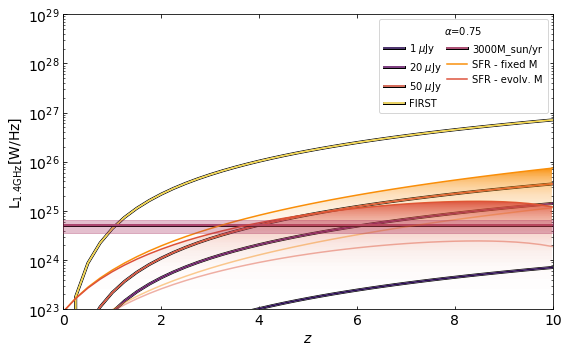

In [30]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(1,1,1)


ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy', color=colors[0], path_effects=pe1)
#ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_20uJy, label='20 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy', color=colors[3], path_effects=pe1)
ax1.plot(z_range, lum_FIRST, label='FIRST', color=colors[5], path_effects=pe1)
ax1.plot(z_range, SFR_3000, label='3000M_sun/yr', color=colors[2], path_effects=pe1)
ax1.fill_between(z_range, SFR_3000 - SFR_3000_e, SFR_3000 + SFR_3000_e, color=colors[2], fc=colors[2], alpha=0.3, zorder=6)
gradient_fill(z_range, max_pow_sfr_fix + 3 * max_pow_sfr_fix_e, fill_color=colors[4], color=colors[4], label='SFR - fixed M', zorder=5, ax=ax1)
ax1.plot(z_range, max_pow_sfr_fix, '-', color=colors[4], alpha=0.45)
gradient_fill(z_range, max_pow_sfr + 3 * max_pow_sfr_e, fill_color=colors[3], color=colors[3], label='SFR - evolv. M', zorder=5, ax=ax1)
ax1.plot(z_range, max_pow_sfr, '-', color=colors[3], alpha=0.45)
ax1.set_xlabel('$z$', size=14, fontweight='bold')
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14, fontweight='bold')
ax1.set_yscale('log')
ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)

vmin = np.log10(L_21cm.min())
vmax = np.log10(L_21cm.max())
bins = np.logspace(vmin, vmax, 75)

ax1.tick_params(which='both',top=True, right=True, direction='in')

ax1.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01)

Now, only draw individual points from surveys or individual studies

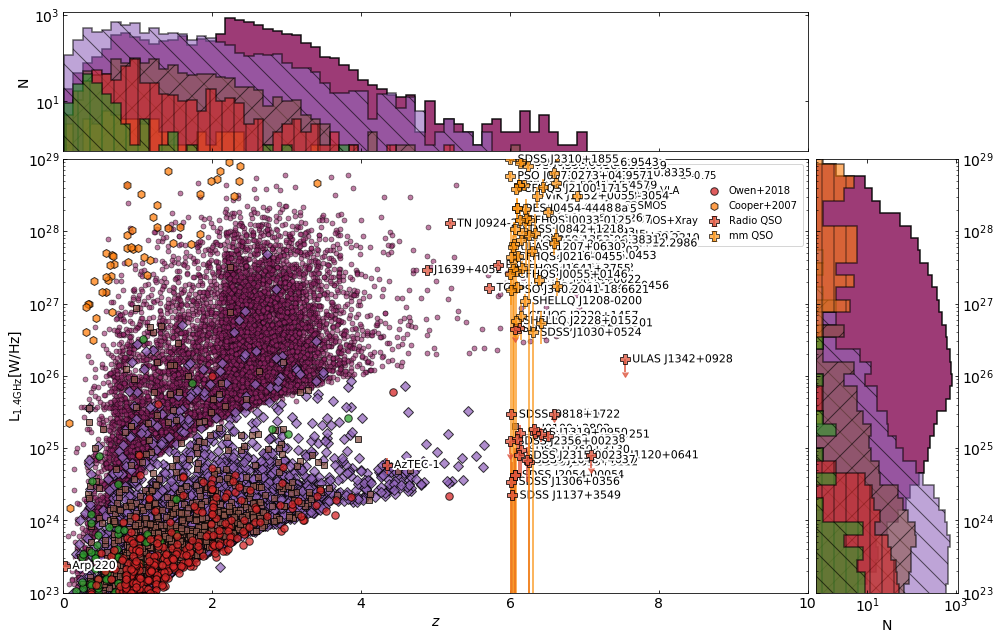

In [31]:
fig = plt.figure(figsize=(14,9))
ax1 = plt.subplot2grid((8,6), (2,0), colspan=5, rowspan=6)
ax2 = plt.subplot2grid((8,6), (2,5), sharey=ax1, rowspan=6)
ax3 = plt.subplot2grid((8,6), (0,0), sharex=ax1, colspan=5, rowspan=2)

#ax1.scatter(sdss_milli['pipeline_redshift'][L_14GHz_filter], L_21cm, c=np.log10(sdss_milli['flux_20_cm'][L_14GHz_filter]), cmap='inferno_r', s=30, alpha=0.75, edgecolor='black', zorder=2)
#cb = plt.colorbar()
#cb.set_label('$\log{(\mathrm{F}_{1.4 \mathrm{GHz}} / \, \mathrm{mJy})}$')
ax1.plot(sdss_milli['redshift'][L_14GHz_filter], L_21cm, color=dark_color, markeredgecolor='k', ms=10, zorder=2, marker='.', mew=0.65, ls='', alpha=0.6, label='FIRST+VLA')
ax1.plot(redshift_cosmos, int_14GHz_cosmos, 'D', color='C4', label='COSMOS', markeredgecolor='k', ms=7, alpha=0.75)
ax1.plot(redshift_cosmos_x, int_14GHz_cosmos_x, 's', color='C5', label='COSMOS+Xray', markeredgecolor='k', ms=6.75, alpha=0.75)
ax1.plot(redshift_wold, lum_wold, '.', color='C2', label='Wold+2012', markeredgecolor='k', ms=15, alpha=0.75)
ax1.plot(redshift_owen, lum_owen, '.', color='C3', label='Owen+2018', markeredgecolor='k', ms=15, alpha=0.75)
ax1.plot(redshift_cooper, lum_cooper, 'h', color='C1', label='Cooper+2007', markeredgecolor='k', ms=8, alpha=0.75)
#ax1.plot(high_z_zs, high_z_lum_14GHz, 'P', color=colors[3], markeredgecolor='k', ms=10, alpha=0.75, zorder=7)
ax1.errorbar(high_z_zs, high_z_lum_14GHz, yerr=high_z_lum_14GHz_e, marker='P', ls='', color=colors[3], markersize=10, zorder=7, alpha=0.75, uplims=high_z_up_lim, elinewidth=2, mec='k', label='Radio QSO')
for zs, lum, name in zip(high_z_zs, high_z_lum_14GHz, high_z_names):
    if lum < 1e23: continue
    elif lum == 0: continue
    elif lum >1e29: continue
    text_str = ax1.text(zs + 0.1, lum * 0.9, name, fontsize=11, fontweight='roman', zorder=6)
    text_str.set_path_effects([path_effects.Stroke(linewidth=4., foreground='white'), path_effects.Normal()])
#ax1.plot(high_z_zs, high_z_lum_250, 'P', color=colors[4], markeredgecolor='k', ms=10, alpha=0.75, zorder=7)
ax1.errorbar(high_z_zs[filter_250GHz], high_z_lum_250[filter_250GHz], yerr=high_z_lum_250GHz_e[filter_250GHz], marker='P', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.65, uplims=high_z_up_lim[filter_250GHz], elinewidth=2, mec='k', label='mm QSO')
for zs, lum, name in zip(high_z_zs[filter_250GHz], high_z_lum_250[filter_250GHz], high_z_names[filter_250GHz]):
    if lum < 1e23: continue
    elif lum == 0: continue
    elif lum >1e29: continue
    text_str = ax1.text(zs + 0.1, lum * 0.9, name, fontsize=11, fontweight='roman', zorder=6)
    text_str.set_path_effects([path_effects.Stroke(linewidth=4., foreground='white'), path_effects.Normal()])
#ax1.errorbar(indiv_zs, indiv_lum, yerr=indiv_lum_e, marker='*', ls='', color='C0', path_effects=pe1, markersize=15, zorder=7, alpha=0.75, uplims=indiv_up_lim, elinewidth=3)
#for zs, lum, name in zip(indiv_zs, indiv_lum, indiv_names):
#    if lum < 1e23: continue
#    text_str = ax1.text(zs + 0.15, lum, name, fontsize=13, fontweight='roman', zorder=7)
#    text_str.set_path_effects([path_effects.Stroke(linewidth=4., foreground='white'), path_effects.Normal()])
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_yscale('log')
ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)

vmin = np.log10(L_21cm.min())
vmax = np.log10(L_21cm.max())
bins = np.logspace(vmin, vmax, 75)
hist(L_21cm, bins=bins, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9, color=dark_color, ec='k', lw=1.5, hatch='')
hist(int_14GHz_cosmos, bins=bins, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.6, color='C4', ec='k', lw=1.5, hatch='\\')
hist(int_14GHz_cosmos_x, bins=bins, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.6, color='C5', ec='k', lw=1.5, hatch='/')
hist(lum_cooper, bins=bins, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.6, color='C1', ec='k', lw=1.5, hatch='|')
hist(lum_owen, bins=bins, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.6, color='C3', ec='k', lw=1.5, hatch='|')
hist(lum_wold, bins=bins, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.6, color='C2', ec='k', lw=1.5, hatch='\\')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('N', size=14)
plt.setp(ax2.get_yticklabels(), visible=False)
vmin_z = high_z_zs.min()
vmax_z = high_z_zs.max()
bins_z = np.linspace(vmin_z, vmax_z, 60)
hist(sdss_milli['redshift'][L_14GHz_filter], bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9, color=dark_color, ec='k', lw=1.5, hatch='')
hist(redshift_cosmos, bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.6, color='C4', ec='k', lw=1.5, hatch='\\')
hist(redshift_cosmos_x, bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.6, color='C5', ec='k', lw=1.5, hatch='/')
hist(redshift_cooper, bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.6, color='C1', ec='k', lw=1.5, hatch='|')
hist(redshift_owen, bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.6, color='C3', ec='k', lw=1.5, hatch='|')
hist(redshift_wold, bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.6, color='C2', ec='k', lw=1.5, hatch='\\')
ax3.set_yscale('log')
ax3.set_ylabel('N', size=14)
plt.setp(ax3.get_xticklabels(), visible=False)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
ax3.tick_params(which='both',top=True, right=True, direction='in')

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01, h_pad=0.01)

Finally, plot all information together

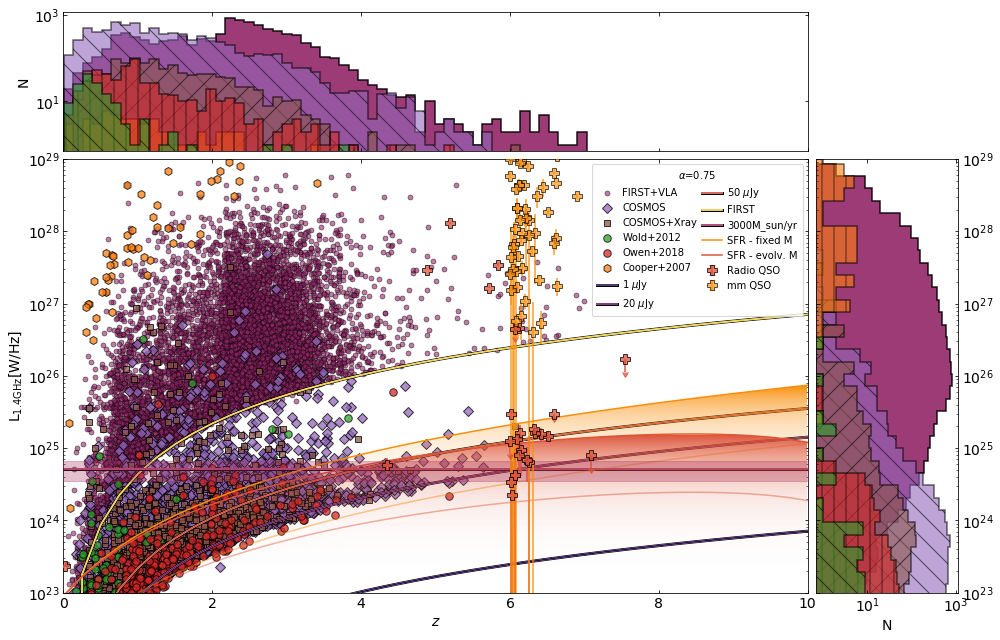

In [32]:
fig = plt.figure(figsize=(14,9))
ax1 = plt.subplot2grid((8,6), (2,0), colspan=5, rowspan=6)
ax2 = plt.subplot2grid((8,6), (2,5), sharey=ax1, rowspan=6)
ax3 = plt.subplot2grid((8,6), (0,0), sharex=ax1, colspan=5, rowspan=2)

#ax1.scatter(sdss_milli['pipeline_redshift'][L_14GHz_filter], L_21cm, c=np.log10(sdss_milli['flux_20_cm'][L_14GHz_filter]), cmap='inferno_r', s=30, alpha=0.75, edgecolor='black', zorder=2)
#cb = plt.colorbar()
#cb.set_label('$\log{(\mathrm{F}_{1.4 \mathrm{GHz}} / \, \mathrm{mJy})}$')
ax1.plot(sdss_milli['redshift'][L_14GHz_filter], L_21cm, color=dark_color, markeredgecolor='k', ms=10, zorder=2, marker='.', mew=0.65, ls='', alpha=0.6, label='FIRST+VLA')
ax1.plot(redshift_cosmos, int_14GHz_cosmos, 'D', color='C4', label='COSMOS', markeredgecolor='k', ms=7, alpha=0.75)
ax1.plot(redshift_cosmos_x, int_14GHz_cosmos_x, 's', color='C5', label='COSMOS+Xray', markeredgecolor='k', ms=6.75, alpha=0.75)
ax1.plot(redshift_wold, lum_wold, '.', color='C2', label='Wold+2012', markeredgecolor='k', ms=15, alpha=0.75)
ax1.plot(redshift_owen, lum_owen, '.', color='C3', label='Owen+2018', markeredgecolor='k', ms=15, alpha=0.75)
ax1.plot(redshift_cooper, lum_cooper, 'h', color='C1', label='Cooper+2007', markeredgecolor='k', ms=8, alpha=0.75)
#ax1.plot(high_z_zs, high_z_lum_14GHz, 'P', color=colors[3], markeredgecolor='k', ms=10, alpha=0.75, zorder=7)
ax1.errorbar(high_z_zs, high_z_lum_14GHz, yerr=high_z_lum_14GHz_e, marker='P', ls='', color=colors[3], markersize=10, zorder=7, alpha=0.75, uplims=high_z_up_lim, elinewidth=2, mec='k', label='Radio QSO')
#for zs, lum, name in zip(high_z_zs, high_z_lum_14GHz, high_z_names):
#    if lum < 1e23: continue
#    elif lum == 0: continue
#    elif lum >1e29: continue
#    text_str = ax1.text(zs + 0.1, lum * 0.9, name, fontsize=11, fontweight='roman', zorder=6)
#    text_str.set_path_effects([path_effects.Stroke(linewidth=4., foreground='white'), path_effects.Normal()])
#ax1.plot(high_z_zs, high_z_lum_250, 'P', color=colors[4], markeredgecolor='k', ms=10, alpha=0.75, zorder=7)
ax1.errorbar(high_z_zs[filter_250GHz], high_z_lum_250[filter_250GHz], yerr=high_z_lum_250GHz_e[filter_250GHz], marker='P', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.65, uplims=high_z_up_lim[filter_250GHz], elinewidth=2, mec='k', label='mm QSO')
#for zs, lum, name in zip(high_z_zs, high_z_lum_250, high_z_names):
#    if lum < 1e23: continue
#    elif lum >1e29: continue
#    elif lum == 0: continue
#    text_str = ax1.text(zs + 0.1, lum * 0.9, name, fontsize=11, fontweight='roman', zorder=6)
#    text_str.set_path_effects([path_effects.Stroke(linewidth=4., foreground='white'), path_effects.Normal()])
ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy', color=colors[0], path_effects=pe1)
# ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_20uJy, label='20 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy', color=colors[3], path_effects=pe1)
ax1.plot(z_range, lum_FIRST, label='FIRST', color=colors[5], path_effects=pe1)
ax1.plot(z_range, SFR_3000, label='3000M_sun/yr', color=colors[2], path_effects=pe1)
ax1.fill_between(z_range, SFR_3000 - SFR_3000_e, SFR_3000 + SFR_3000_e, color=colors[2], fc=colors[2], alpha=0.3, zorder=6)
gradient_fill(z_range, max_pow_sfr_fix + 3 * max_pow_sfr_fix_e, fill_color=colors[4], color=colors[4], label='SFR - fixed M', zorder=5, ax=ax1)
ax1.plot(z_range, max_pow_sfr_fix, '-', color=colors[4], alpha=0.45)
gradient_fill(z_range, max_pow_sfr + 3 * max_pow_sfr_e, fill_color=colors[3], color=colors[3], label='SFR - evolv. M', zorder=5, ax=ax1)
ax1.plot(z_range, max_pow_sfr, '-', color=colors[3], alpha=0.45)
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_yscale('log')
ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)
vmin_L = np.log10(L_21cm.min())
vmax_L = np.log10(L_21cm.max())
bins_L = np.logspace(vmin_L, vmax_L, 75)
hist(L_21cm, bins=bins_L, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9, color=dark_color, ec='k', lw=1.5, hatch='')
hist(int_14GHz_cosmos, bins=bins_L, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.6, color='C4', ec='k', lw=1.5, hatch='\\')
hist(int_14GHz_cosmos_x, bins=bins_L, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.6, color='C5', ec='k', lw=1.5, hatch='/')
hist(lum_cooper, bins=bins_L, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.6, color='C1', ec='k', lw=1.5, hatch='|')
hist(lum_owen, bins=bins_L, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.6, color='C3', ec='k', lw=1.5, hatch='|')
hist(lum_wold, bins=bins_L, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.6, color='C2', ec='k', lw=1.5, hatch='\\')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('N', size=14)
plt.setp(ax2.get_yticklabels(), visible=False)
vmin_z = high_z_zs.min()
vmax_z = high_z_zs.max()
bins_z = np.linspace(vmin_z, vmax_z, 60)
hist(sdss_milli['redshift'][L_14GHz_filter], bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9, color=dark_color, ec='k', lw=1.5, hatch='')
hist(redshift_cosmos, bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.6, color='C4', ec='k', lw=1.5, hatch='\\')
hist(redshift_cosmos_x, bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.6, color='C5', ec='k', lw=1.5, hatch='/')
hist(redshift_cooper, bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.6, color='C1', ec='k', lw=1.5, hatch='|')
hist(redshift_owen, bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.6, color='C3', ec='k', lw=1.5, hatch='|')
hist(redshift_wold, bins=bins_z, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.6, color='C2', ec='k', lw=1.5, hatch='\\')
ax3.set_yscale('log')
ax3.set_ylabel('N', size=14)
plt.setp(ax3.get_xticklabels(), visible=False)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
ax3.tick_params(which='both',top=True, right=True, direction='in')

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01, h_pad=0.01)

Create a plot showing, in addition, the SFR values.

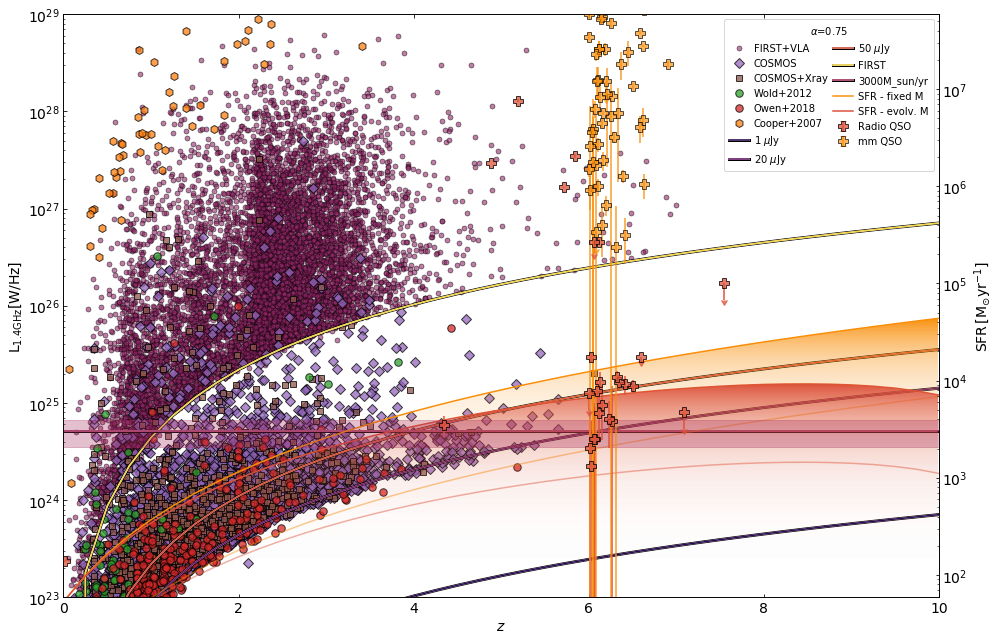

In [33]:
fig = plt.figure(figsize=(14,9))
ax1 = fig.add_subplot(111)


ax1.plot(sdss_milli['redshift'][L_14GHz_filter], L_21cm, color=dark_color, markeredgecolor='k', ms=10, zorder=2, marker='.', mew=0.65, ls='', alpha=0.6, label='FIRST+VLA')
ax1.plot(redshift_cosmos, int_14GHz_cosmos, 'D', color='C4', label='COSMOS', markeredgecolor='k', ms=7, alpha=0.75)
ax1.plot(redshift_cosmos_x, int_14GHz_cosmos_x, 's', color='C5', label='COSMOS+Xray', markeredgecolor='k', ms=6.75, alpha=0.75)
ax1.plot(redshift_wold, lum_wold, '.', color='C2', label='Wold+2012', markeredgecolor='k', ms=15, alpha=0.75)
ax1.plot(redshift_owen, lum_owen, '.', color='C3', label='Owen+2018', markeredgecolor='k', ms=15, alpha=0.75)
ax1.plot(redshift_cooper, lum_cooper, 'h', color='C1', label='Cooper+2007', markeredgecolor='k', ms=8, alpha=0.75)
#ax1.plot(high_z_zs, high_z_lum_14GHz, 'P', color=colors[3], markeredgecolor='k', ms=10, alpha=0.75, zorder=7)
ax1.errorbar(high_z_zs, high_z_lum_14GHz, yerr=high_z_lum_14GHz_e, marker='P', ls='', color=colors[3], markersize=10, zorder=7, alpha=0.75, uplims=high_z_up_lim, elinewidth=2, mec='k', label='Radio QSO')
#for zs, lum, name in zip(high_z_zs, high_z_lum_14GHz, high_z_names):
#    if lum < 1e23: continue
#    elif lum == 0: continue
#    text_str = ax1.text(zs + 0.1, lum, name, fontsize=11, fontweight='roman', zorder=6)
#    text_str.set_path_effects([path_effects.Stroke(linewidth=4., foreground='white'), path_effects.Normal()])
#ax1.plot(high_z_zs, high_z_lum_250, 'P', color=colors[4], markeredgecolor='k', ms=10, alpha=0.75, zorder=7)
ax1.errorbar(high_z_zs[filter_250GHz], high_z_lum_250[filter_250GHz], yerr=high_z_lum_250GHz_e[filter_250GHz], marker='P', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.65, uplims=high_z_up_lim[filter_250GHz], elinewidth=2, mec='k', label='mm QSO')
#for zs, lum, name in zip(high_z_zs, high_z_lum_250, high_z_names):
#    if lum < 1e23: continue
#    elif lum == 0: continue
#    text_str = ax1.text(zs + 0.1, lum, name, fontsize=11, fontweight='roman', zorder=6)
#    text_str.set_path_effects([path_effects.Stroke(linewidth=4., foreground='white'), path_effects.Normal()])
ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy', color=colors[0], path_effects=pe1)
# ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_20uJy, label='20 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy', color=colors[3], path_effects=pe1)
ax1.plot(z_range, lum_FIRST, label='FIRST', color=colors[5], path_effects=pe1)
ax1.plot(z_range, SFR_3000, label='3000M_sun/yr', color=colors[2], path_effects=pe1)
ax1.fill_between(z_range, SFR_3000 - SFR_3000_e, SFR_3000 + SFR_3000_e, color=colors[2], fc=colors[2], alpha=0.3, zorder=6)
gradient_fill(z_range, max_pow_sfr_fix + 3 * max_pow_sfr_fix_e, fill_color=colors[4], color=colors[4], label='SFR - fixed M', zorder=5, ax=ax1)
ax1.plot(z_range, max_pow_sfr_fix, '-', color=colors[4], alpha=0.45)
gradient_fill(z_range, max_pow_sfr + 3 * max_pow_sfr_e, fill_color=colors[3], color=colors[3], label='SFR - evolv. M', zorder=5, ax=ax1)
ax1.plot(z_range, max_pow_sfr, '-', color=colors[3], alpha=0.45)
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_yscale('log')
ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
#ax1.set_xlim(left=4, right=10)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)


ax2 = ax1.twinx()
ax2.set_ylabel('$\mathrm{SFR}\, [\mathrm{M}_{\odot} \mathrm{yr}^{-1}]$', size=14)
ax2.set_ylim((1e23 * 5.9e-22, 1e29 * 5.9e-22))
ax2.set_yscale('log')
ax2.figure.canvas.draw()

#plt.setp(ax2.get_yticklabels(), visible=False)
ax1.tick_params(which='both',top=True, right=False, direction='in')
ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01)

We also want to understand the correlation between mm and radio fluxes,  
when available. In order to characterize it, we use the Radio-to-millimetre  
spectral index, $\alpha^{250\mathrm{GHz}}_{1.4\mathrm{GHz}}$.

In order to calculate this value, we use, as mentioned earlier, the definition  
from **Butler et al., 2018**, but modified for the desired frequencies:

$$\alpha^{250\mathrm{GHz}}_{1.4\mathrm{GHz}} = \frac{\log_{10}{(S_{250\mathrm{GHz}} / S_{1.4\mathrm{GHz}})}} {\log_{10}{(1.4\mathrm{GHz} / 250\mathrm{GHz})}}$$

This relation can be, then, rearanged to:

$$\alpha^{250\mathrm{GHz}}_{1.4\mathrm{GHz}} \approx -0.44 \times \log_{10}{(S_{250\mathrm{GHz}} / S_{1.4\mathrm{GHz}})}$$

A small number of sources show both, radio and millimetre data.  
We can plot their spectral indices.

In [34]:
filter_250_14     = np.array((high_z_lum_250 > 0) * (high_z_lum_14GHz > 0)) * ~high_z_up_lim
spec_idx_250_14   = np.log10(high_z_250GHz[filter_250_14] / high_z_14[filter_250_14]) * np.log10(250 / 1.4)
spec_idx_250_14_e = (1 / np.log(10)) * np.sqrt((high_z_250GHz_e[filter_250_14] / high_z_250GHz[filter_250_14])**2 + (high_z_14_e[filter_250_14] / high_z_14[filter_250_14])**2)

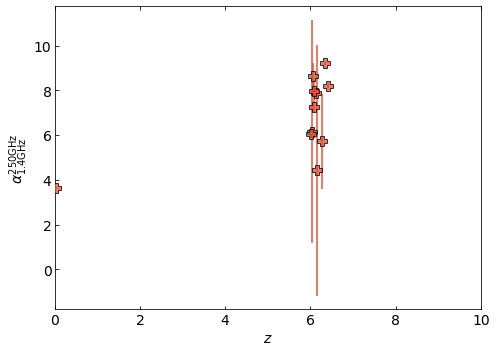

In [35]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)


#ax1.plot(high_z_zs[filter_250_14], spec_idx_250_14, color=colors[3], markeredgecolor='k', ms=18, zorder=2, marker='.', mew=0.65, ls='', alpha=0.6)
ax1.errorbar(high_z_zs[filter_250_14], spec_idx_250_14, yerr=spec_idx_250_14_e, marker='P', ls='', color=colors[3], markersize=10, zorder=7, alpha=0.75, uplims=None, elinewidth=2, mec='k', label='Radio QSO')
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel(r'$\alpha^{250\mathrm{GHz}}_{1.4\mathrm{GHz}}$', size=14)
#ax1.set_xscale('log')
#ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
#ax1.set_xlim(left=4, right=10)

ax1.tick_params(which='both',top=True, right=False, direction='in')

ax1.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01)